# Ames Iowa Technical Report 
   ### By Isaiah Westphalen

------------------------------

#### Problem Statement: 
    In order to help the city of Ames, Iowa figure out how to best predict home values in certain neighborhoods, develop an idea of what the most important factors are for selling a house, and to help residents interested in selling, this report studies the trends in housing sales from Ames during the timespan of 2006-2010.

#### Getting Started:


First thing is to make the import statements:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler


Next, the Ames housing data:

In [2]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

#### Cleaning:
Now the data needs to be cleaned in order to be usable. Since there are only a few columns in the dataframe that contain null values they'll be removed:

In [3]:
remove_nans = train.isin([np.nan])*1
nan_cols = []
for i in list(remove_nans.columns):
    if remove_nans[i].sum()!= 0:
        nan_cols.append(i)
train.drop(columns = nan_cols, inplace=True)
test.drop(columns = nan_cols, inplace=True)

Removing more extraneous columns:

In [4]:
train_cols = []
for i in list(train.columns):
    if i != 'SalePrice':
        train_cols.append(i)
test_col = list(test.columns) 
remove_train = []
remove_test = []
for i in train_cols:
    if i not in test_col:
        remove_train.append(i)
for i in test_col:
    if i not in train_cols:
        remove_test.append(i)
test.drop(columns = remove_test, inplace=True)
train.drop(columns = remove_train, inplace=True)

Changing the Categorical Data into Dummy Columns:

In [5]:
for i in list(train.columns):
    if train[i].dtypes != int:
        if i!='Neighborhood':
            train = pd.get_dummies(data = train, columns = [i] )
for i in list(test.columns):
    if test[i].dtypes != int:
        test = pd.get_dummies(data = test, columns = [i] )

In [6]:
def neg_zero(x):
    if x<0:
        return 0
    else:
        return x

Making columns for home age and age since remodeling:

In [7]:
train['age_home'] = train['Yr Sold'] - train['Year Built']
train['age_home'] = train['age_home'].map(neg_zero)
test['age_home'] = test['Yr Sold'] - test['Year Built']
test['age_home'] = test['age_home'].map(neg_zero)
train['age_remod'] = train['Yr Sold']-train['Year Remod/Add']
train['age_remod']=train['age_remod'].map(neg_zero)
test['age_remod'] = test['Yr Sold']-test['Year Remod/Add']
test['age_remod'] = test['age_remod'].map(neg_zero)

Removing more extraneous columns: 

In [8]:
train.drop(columns = ['Year Built', 'Yr Sold', 'Id', 'PID','Year Remod/Add','Mo Sold'], inplace = True)
test.drop(columns = ['Year Built', 'Yr Sold', 'Id','PID','Year Remod/Add','Mo Sold'], inplace = True)

Changing neighborhood names to full names:

In [9]:
actual_names ={'Blmngtn':'Bloomington Heights',
       'Blueste':'Bluestem',
       'BrDale':'Briardale',
       'BrkSide':'Brookside',
       'ClearCr':'Clear Creek',
       'CollgCr':'College Creek',
       'Crawfor':'Crawford',
       'Edwards':'Edwards',
       'Gilbert':'Gilbert',
       'Greens':'Greens',
       'GrnHill':'Green Hills',
       'IDOTRR':'Iowa DOT and Rail Road',
       'Landmrk':'Landmark',
       'MeadowV':'Meadow Village',
       'Mitchel':'Mitchell',
       'NAmes':'North Ames',
       'NoRidge':'Northridge',
       'NPkVill':'Northpark Villa',
       'NridgHt':'Northridge Heights',
       'NWAmes':'Northwest Ames',
       'OldTown':'Old Town',
       'SWISU':'South & West of Iowa State University',
       'Sawyer':'Sawyer',
       'SawyerW':'Sawyer West',
       'Somerst':'Somerset',
       'StoneBr':'Stone Brook',
       'Timber':'Timberland',
       'Veenker':'Veenker'}

In [10]:
train['Neighborhood'].replace(actual_names, inplace=True)

In [11]:
names = list(train['Neighborhood'].unique())

#### Now that the data has been cleaned it can be investigated:

Here we'll look at the top ten neighborhoods in terms of average sale price:

In [12]:
mean_dic = {}
for i in names:
    df = train[train['Neighborhood']==i]
    base = df['SalePrice'].mean()
    df2 = df[df['SalePrice']>base]
    mean_dic[i] = [base, len(df), len(df2),len(df2)/ len(df)]
comparing_neighs = pd.DataFrame(data = mean_dic, index = ['Average Price', 'Number Sold','Number Sold Above Ames Average', 'Proportion']).T.reset_index()
comparing_neighs=comparing_neighs.sort_values(by='Average Price', ascending = False).reset_index()
comparing_neighs=comparing_neighs.drop(columns = ['level_0'])
comparing_neighs=comparing_neighs.rename(columns = {'index':'Neighborhood'})
comparing_neighs.head(10)

,Neighborhood,Average Price,Number Sold,Number Sold Above Ames Average,Proportion
0,Stone Brook,329675.736842,38.0,18.0,0.473684
1,Northridge Heights,322831.352459,122.0,55.0,0.450820
2,Northridge,316294.125000,48.0,19.0,0.395833
3,Green Hills,280000.000000,2.0,1.0,0.500000
4,Veenker,253570.588235,17.0,9.0,0.529412
5,Timberland,241051.354167,48.0,22.0,0.458333
6,Somerset,227183.900000,130.0,60.0,0.461538
7,Clear Creek,217490.074074,27.0,14.0,0.518519
8,Crawford,205901.211268,71.0,31.0,0.436620
9,College Creek,202497.216667,180.0,87.0,0.483333


Here we can see that Stone Brook on average has the highest selling houses at a mean price of $329675.73, and 47% of houses being sold above the Ames city average.

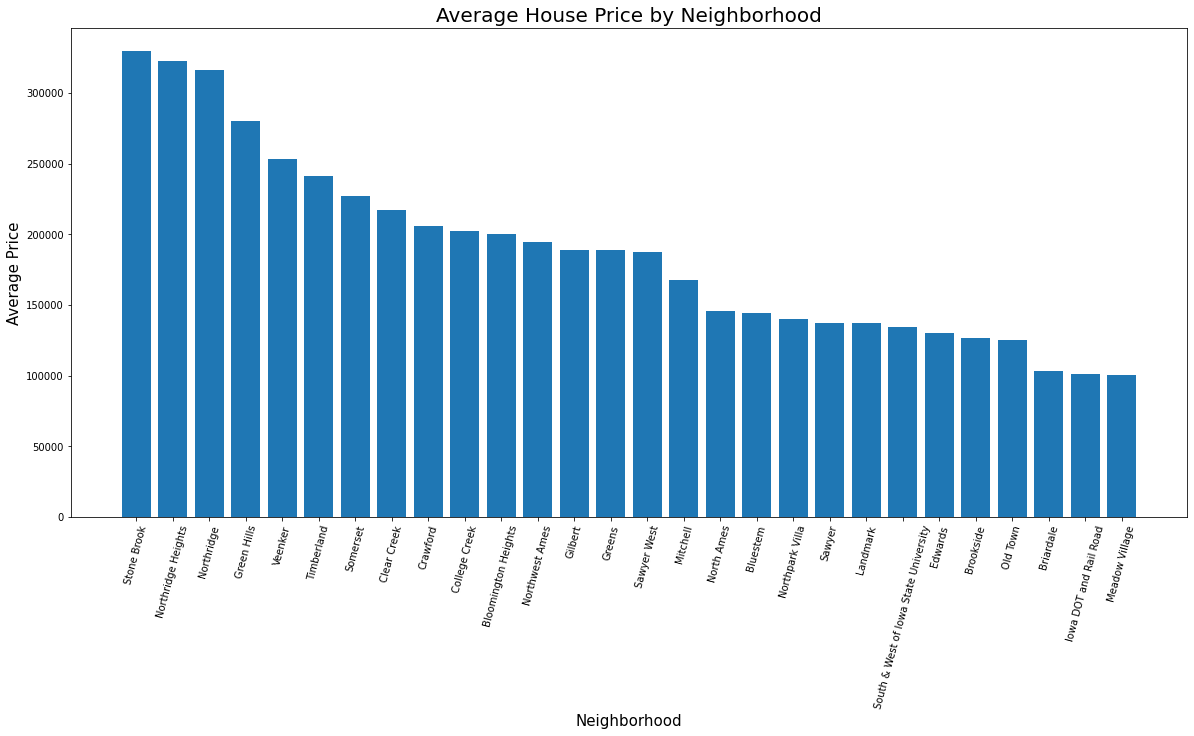

In [13]:
plt.figure(figsize = (20,9))
plt.bar(x =comparing_neighs['Neighborhood'],height=comparing_neighs['Average Price'])
plt.title('Average House Price by Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Average Price', fontsize =15)
plt.xticks(rotation = 75);

Here the mean price per neighborhoood can be seen for all the data. Again, Stony Brook had the highest price and Meadow Village the lowest.

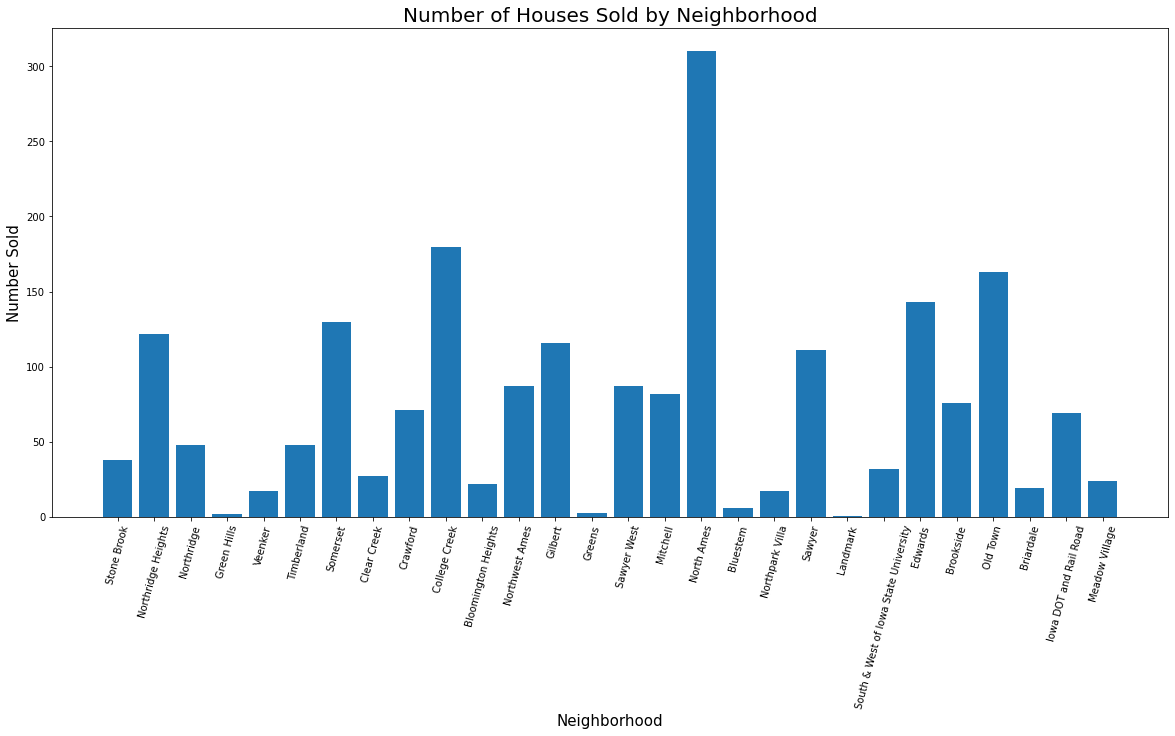

In [14]:
plt.figure(figsize = (20,9))
plt.bar(x =comparing_neighs['Neighborhood'],height=comparing_neighs['Number Sold'])
plt.title('Number of Houses Sold by Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Number Sold', fontsize =15)
plt.xticks(rotation = 75);

Here the number of houses per neighborhood can be seen, the most being sold in North Ames.

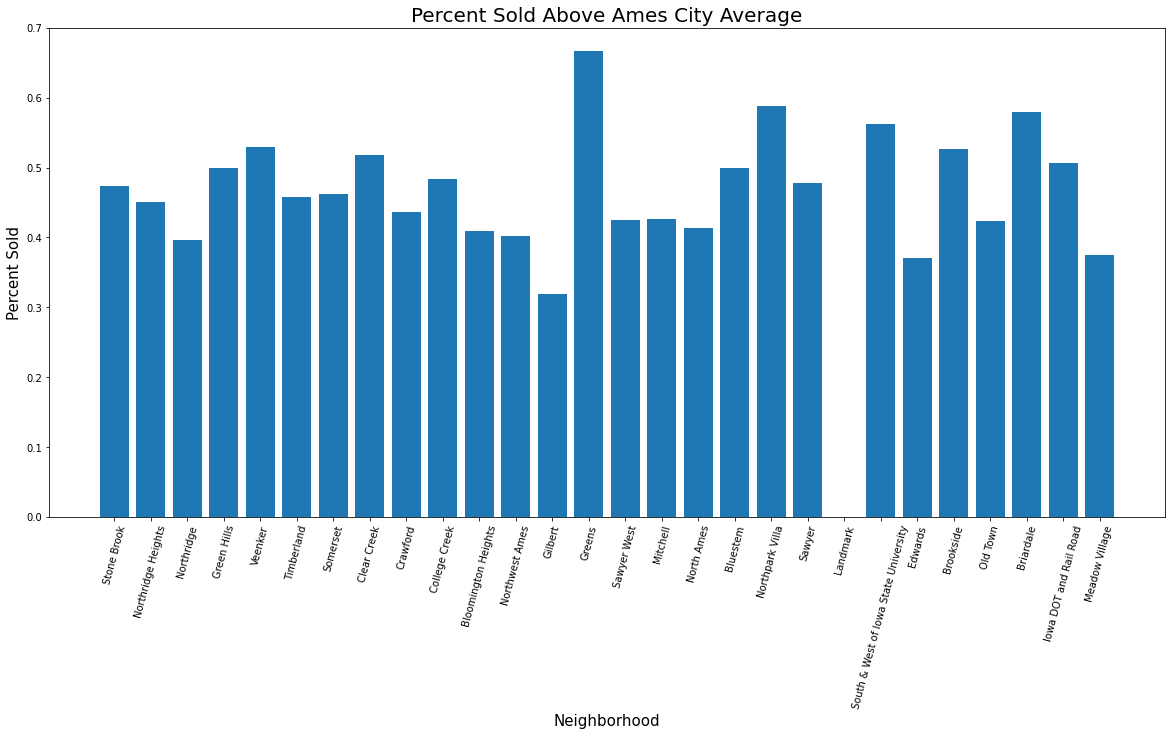

In [15]:
plt.figure(figsize = (20,9))
plt.bar(x =comparing_neighs['Neighborhood'],height=comparing_neighs['Proportion'])
plt.title('Percent Sold Above Ames City Average', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Percent Sold', fontsize =15)
plt.xticks(rotation = 75);

Here the percent of homes sold above the Ames city average can be seen. Greens has sold the highest proportion of its houses at above the Ames average, whereas Landmark has sold none.

Now it's time to start looking at the actual factors that cause changes in a house's sale price. This will be done by taking the correlation of all the factors with respect to a neighborhood's sale prices, and the factors that have the ten highest correlations will be used to determine what kind of regression model will be used:

In [16]:

cols_d = {}
neigh_rmse = []
comparison={}
for i in names:
    try:
        df = train[train['Neighborhood']==i]
        if len(df)>10:
            model_rmse = []
            baseline = df['SalePrice'].mean()
            corr = np.abs(df.corr())
            cols = list(corr.nlargest(11, 'SalePrice').index)[1:]
            for fac in cols:
                if fac in cols_d:
                    cols_d[fac]+=1
                else:
                    cols_d[fac] = 1
            X = df[cols]
            y = np.log(df['SalePrice'])
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)
            
            sc = StandardScaler()
            sc.fit(X_train, y_train)
            Z_train = sc.transform(X_train)
            Z_test = sc.transform(X_test)
            
            lr = LinearRegression()
            lr.fit(Z_train, y_train)
            preds1 = lr.predict(Z_test)
            ols = mean_squared_error(np.e**y_test, np.e**preds1, squared=False)
            model_rmse.append(ols)
            
            rd = Ridge()
            rd.fit(Z_train, y_train)
            preds2 = rd.predict(Z_test)
            ridge = mean_squared_error(np.e**y_test,np.e**preds2, squared=False )
            model_rmse.append(ridge)
            
            basermse = mean_squared_error((np.e**y_test), np.array(len(y_test)*[(np.e**y_test).mean()]), squared = False)
            comparison[i]=[basermse,ridge]
            
            
            ls = Lasso()
            ls.fit(Z_train, y_train)
            preds3 = ls.predict(Z_test)
            lasso = mean_squared_error(np.e**y_test, np.e**preds3, squared=False)
            model_rmse.append(lasso)
            neigh_rmse.append(model_rmse)
            
    except:
        print('there was an error')
model_ols = []
model_ridge = []
model_lasso = []

for i in range(len(neigh_rmse)):
    model_ols.append(neigh_rmse[i][0])
    model_ridge.append(neigh_rmse[i][1])
    model_lasso.append(neigh_rmse[i][2])
which_smallest = min(list([[sum(model_ols)/len(model_ols),'Linear Regression'], [sum(model_ridge)/len(model_ridge), 'Ridge Regression'],
                           [sum(model_lasso)/len(model_lasso), 'Lasso']]))

print(f"The smallest average RMSE score was {which_smallest[0]}, so the model that will be used across all neighborhoods will be: {which_smallest[1]}")

The smallest average RMSE score was 25953.141507755805, so the model that will be used across all neighborhoods will be: Ridge Regression


Next, to determine if this model is going to perform well in the furture it can be compared to the baseline (mean price) for each neighborhood. To do this, the Root Mean Squared Error for the predictions from our model will be compared to the baseline's RMSE:

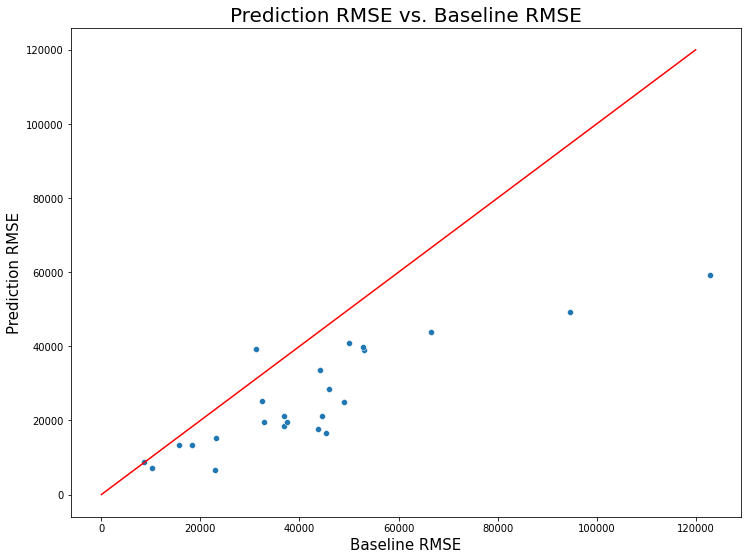

In [17]:
a = pd.DataFrame(comparison, index=['Baseline RMSE', 'Model RMSE']).T.reset_index()
plt.figure(figsize = (12,9))
sns.scatterplot(x = a['Baseline RMSE'], y =a['Model RMSE'])

plt.title('Prediction RMSE vs. Baseline RMSE', fontsize = 20)
plt.xlabel('Baseline RMSE', fontsize = 15)
plt.ylabel('Prediction RMSE', fontsize = 15)
x=[i for i in range(120000)]
y = [i for i in range(120000)]
plt.plot(x, y, color = 'red');

Here we can see that the ridge model performs significantly better than the baseline. The line plotted shows what a 1:1 relationship between prediction and baseline would look like. It can be seen that the overwhelming majority of our data is beneath the line, which shows that errors from the baseline are more significant than the model's predictions.

Now, looking at the most common features that determine a house's sale price:

In [18]:
factors = pd.DataFrame(data = cols_d, index = ['NUM']).T.reset_index()
factors=factors.sort_values(by = 'NUM', ascending=False).reset_index()
factors=factors.drop(columns = ['level_0'])
factors = factors.iloc[:20]

In [19]:
def actual(x):
    feat_names = {'SalePrice':'Sale Price', 'Gr Liv Area':'Above Grade Living Area', 'Fireplaces':'Fire Places',
              '1st Flr SF':'First Floor Sq Ft',
             'Wood Deck SF': 'Wood Deck Sq Ft',
             '2nd Flr SF': 'Second Floor Sq Ft',
             'TotRms AbvGrd':'Total Rooms Above Grade',
             'age_home':'Age of the House',
             'Lot Area': 'Lot Size (Sq Ft)',
             'Half Bath': 'Number Half Bathrooms',
             'age_remod':'Age of Remodel',
             'Full Bath':'Number Full Bathrooms',
             'Misc Val': 'Value of Miscellaneous Features',
             'Screen Porch':'Screen Porch Sq Ft',
             'Open Porch SF':'Open Porch Area (Sq Ft)',
             'Overall Qual':'Overall Quality',
             'Overall Cond': 'Overall Condition',
             'MS SubClass':'Type of House',
             'Enclosed Porch':'Enclosed Porch Area (Sq Ft)',
             'Bedroom AbvGr':'Bedrooms Above Grade',
             'Low Qual Fin SF':'Sq Ft of Low Quality Finish',
             '3Ssn Porch': 'Sq Ft of 3 season Porch',
             'Kitchen AbvGr':'Kitchens Above Grade',
             'Pool Area': 'Area of Pool (Sq Ft)',
                 'Kitchen Qual_Ex':'Excellent Kitchen Quality',
                 'Exter Qual_TA':'Average Exterior Quality',
                 'Kitchen Qual_TA': 'Average Kitchen Quality',
                 'Kitchen Qual_Gd': 'Good Kitchen Quality',
                 'Bldg Type_1Fam': 'One Family House',
                 'Roof Style_Gable': 'Gable Roof Type',
                 'Exter Qual_Ex': 'Excellent Exterior Quality'}
    return feat_names[x]
factors['actual']=factors['index'].map(actual)

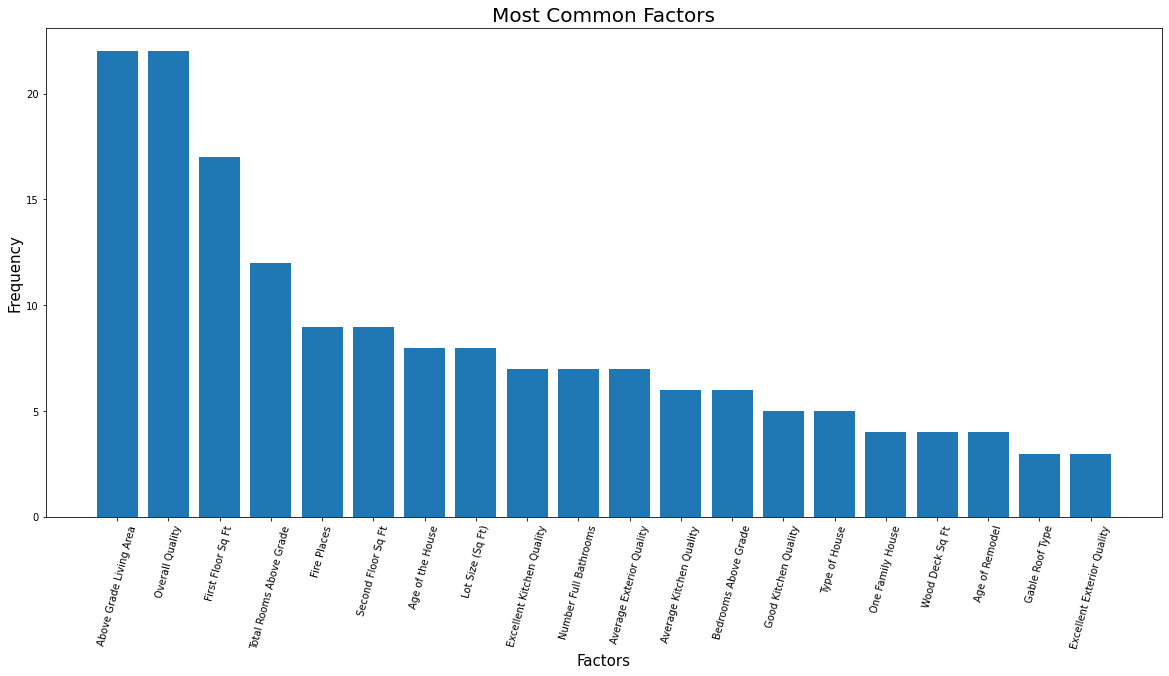

In [20]:
plt.figure(figsize = (20,9))
plt.bar(x = factors['actual'], height=factors['NUM'])
plt.xticks(rotation = 75)
plt.title('Most Common Factors', fontsize=20)
plt.xlabel('Factors', fontsize =15)
plt.ylabel('Frequency', fontsize = 15);

This visual shows how many times different factors that determine house price were used in the modeling step. Obviously, the most common was the total above ground living space that each house had. Other important factors were the quality of the house's kitchen and exterior.


### Conclusion:

- From investigating the Ames city housing data neighborhood by neighborhood, it can be seen that the neighborhood with the highest average sale price is Stone Brook, while the lowest is Meadow Village
- Generally each neighborhood is able to sell around 50 percent of its houses at above Ames' city average, which is to be expected. Landmark however sold no houses above the Ames average. 
- There are definite trends in what factors affect sale price across neighborhoods, with heavy emphasis on house condition and living space.  

### Recommendations:

- More precise investigation should be done neighborhood by neighborhood to see what specific trends exist - comparing how significant of a correlation that a certain factor has in one neighborhood as opposed to its correlation in another neighborhood would be insightful
- Discussing which factors are most important with residents can help homeowners prepare for the selling process. Generally the most significant factors being: living space and home quality (but findings from a specific study of a neighborhood would be helpful) 
- Determining how to assist residents with remodeling would be in the city's best interest for raising house sale price
 